# Loading of Data from G.Cloud


Confirming the Working Directory

In [ ]:
import os
os.chdir('/content')
print(" Current Working Directory")
% pwd

 Current Working Directory


'/content'

#Installing all dependencies 

In [ ]:
!pip install pandas sklearn fbprophet seaborn

Importing Python Packages

In [ ]:
!wget -P /content https://ti.arc.nasa.gov/c/3/ 

index.html           51%[=========>          ] 531.91M  15.1MB/s    eta 24s    ^C


In [ ]:
!unzip 'index.html'

Archive:  index.html
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of index.html or
        index.html.zip, and cannot find index.html.ZIP, period.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Common imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

Connecting to G.Cloud Account where data has been stored. Needs Google ID and Password for Verfication.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
# Download a file based on its file ID
file_id = '1bljNTBDZr701KXs8wfPB6KAyi8dtM8QG'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('data.zip')
print('Downloaded Data File')

Downloaded Data File


In [ ]:
# Unzipping the data file
!unzip data.zip

The data is downloaded into the remote instance as data in the /content folder and is used for analytics.

In [ ]:
# renaming file from 2nd_test to vdata
os.rename('2nd_test','data')

# Understanding the Data

Measurement files are available as seperate files (Total 984)

Start of Directory Data<br>
data/2004.02.12.10.32.39   (12th Feb, 2004) <br>
data/2004.02.12.10.42.39 

End Directory Data<br>
data/2004.02.19.06.12.39   (19th Feb, 2004) <br>
data/2004.02.19.06.22.39

Each file contains 10mins of accelerometer data.

##Data Wrangling
Each of the 10min file is averaged and stored to a pandas dataframe 

In [ ]:
data_dir = 'data'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [ ]:
# Check - Begining of Data
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [ ]:
# Check - End of Data
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


In [ ]:
#Check Total Points
print(f'Total Data Points= {merged_data.shape[0] + 1}')

Total Data Points= 984


# Visualising Vibration Data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

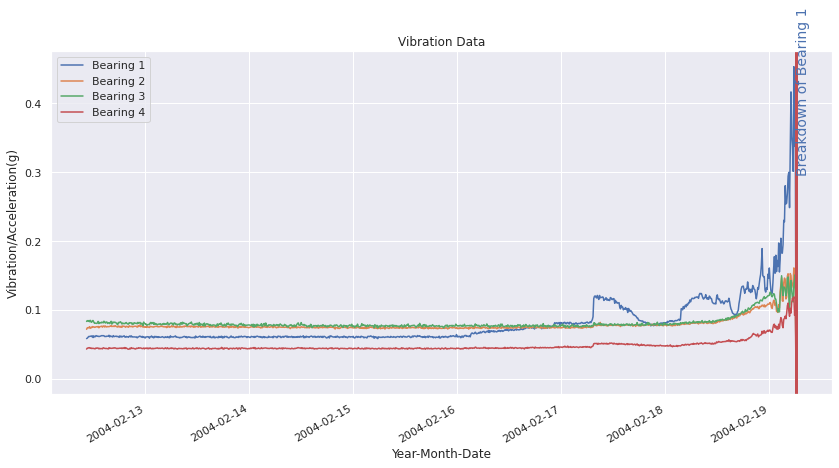

In [ ]:
# Visualising Data
ax = merged_data.plot(figsize = (14,7), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=3, color='r', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

The above figure shows the accelereometer data for all four bearings. Bearing 1 fails at end of measurement, @ 2004-02-19 06:22:39. 

Observing the time plot, it is pretty obvious that the vibration increases after 2004-02-16. However, how does a machine access that there has been an increase in bearing vibration?


## Zooming in Data for Bearing 1

[Text(0, 0.5, 'Vibration/Acceleration(g)'), Text(0.5, 0, 'Month-Date Time')]

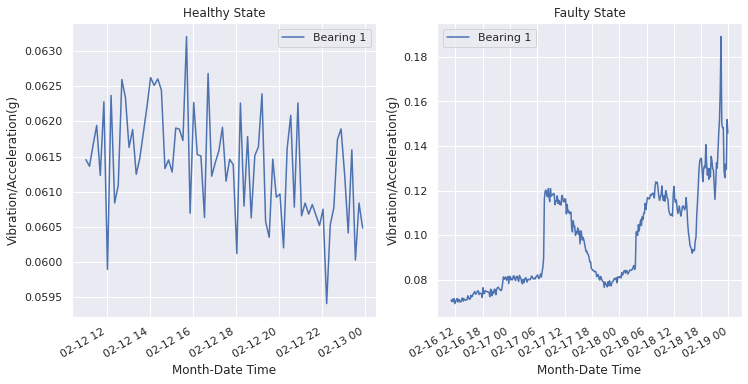

In [ ]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

healthy = merged_data['2004-02-12 11:02:39':'2004-02-12 23:52:39']
healthy['Bearing 1'].plot(figsize = (12,6), title="Healthy State" , legend = True, ax=ax1)
ax1.set(xlabel="Month-Date Time", ylabel="Vibration/Acceleration(g)")


faulty = merged_data['2004-02-18 11:02:39':'2004-02-18 23:52:39']
ax2 = faulty['Bearing 1'].plot(figsize = (12,6), title="Faulty State" , legend = True, ax= ax2)
ax2.set(xlabel="Month-Date Time", ylabel="Vibration/Acceleration(g)")



# Anamoly Detection using Prophet Package (Black Box Modelling)

Anomaly detection problem for time series can be formulated as finding outlier data points relative to some standard or usual signal. Our focus shall be from a machine persopective, such as unexpected spikes, level shift pointing to deteriorating health of a machine.

Prophet is open source software released by Facebook’s Core Data Science team.


In [ ]:
from fbprophet import Prophet

## Creating Training Data Set
The training of the anamoly detection model is using data from the healthy phase of the bearing. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
healthy_bearing1 = merged_data['2004-02-12 10:32:39':'2004-02-15 23:42:39']['Bearing 1']

# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy_bearing1.index
prophet_healthy_train['y'] = healthy_bearing1.values

prophet_healthy_train.head(10)

,ds,y
0,2004-02-12 10:32:39,0.058333
1,2004-02-12 10:42:39,0.058995
2,2004-02-12 10:52:39,0.060236
3,2004-02-12 11:02:39,0.061455
4,2004-02-12 11:12:39,0.061361
5,2004-02-12 11:22:39,0.061665
6,2004-02-12 11:32:39,0.061944
7,2004-02-12 11:42:39,0.061231
8,2004-02-12 11:52:39,0.062280
9,2004-02-12 12:02:39,0.059890


## Creating the Model 

Calling the In-Bulit Prophet Module for training a model

In [ ]:
m = Prophet(interval_width = 1)
# Using the training data from "healthy part"
m.fit(prophet_healthy_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


## Evaluation on Training Data

Displaying Prophet plot---->


[Text(45.125, 0.5, 'Vibration/Acceleration(g)'),
 Text(0.5, 30.5, 'Month (MM)-Date(DD) Time')]

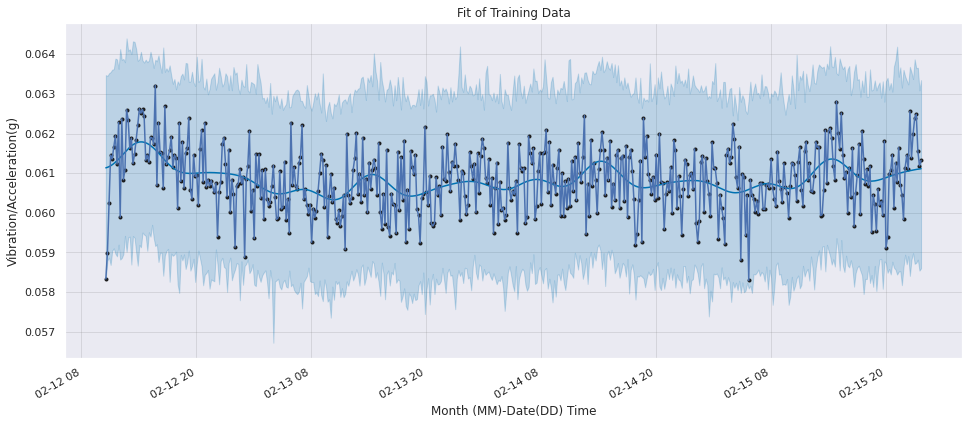

In [ ]:
forecast = m.predict(prophet_healthy_train)
forecast['fact'] = prophet_healthy_train['y'].reset_index(drop = True)
print('Displaying Prophet plot---->')
fig1 = m.plot(forecast)
fig1 = healthy_bearing1.plot(figsize = (14,6), title="Fit of Training Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")


The black points are the true data points of the vibration sensor. The blue line represents the fitted line (trend line) with the light blue portion showing the acceptable variance.

## Evaluation on Test Data (Unseen, Fault Data)

Finally, the moment of truth!

Can the model developed above detect faulty machine condition. To evaluate this, the fault portion of the data is fed into the model.

Note that this data has not been trained by the training model. 

Displaying Prophet plot


Text(731624.875, 0.057, 'Actual/Healthy')

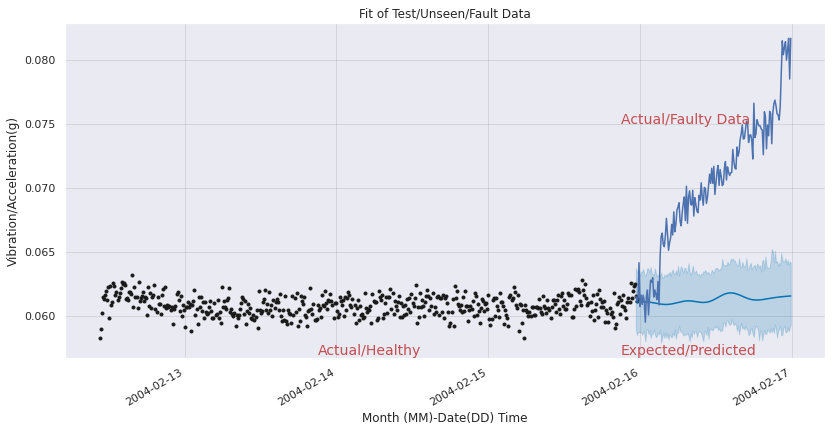

In [ ]:
prophet_faultydata = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
prophet_faultydata.head()

prophet_faulty_test = pd.DataFrame()

prophet_faulty_test['ds'] = prophet_faultydata.index
#pd.to_datetime(prophet_healthy.index, format='%Y.%m.%d.%H.%M.%S')
prophet_faulty_test['y'] = prophet_faultydata.values

forecast = m.predict(prophet_faulty_test)
forecast['fact'] = prophet_faulty_test['y'].reset_index(drop = True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = prophet_faultydata.plot(figsize = (12,6),title="Fit of Test/Unseen/Fault Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")
fig1.text(731626.875,0.057,'Expected/Predicted', fontsize=14, color='r')
fig1.text(731626.875,0.075,'Actual/Faulty Data', fontsize=14, color='r')
fig1.text(731624.875,0.057,'Actual/Healthy', fontsize=14, color='r')

The black points are the true data points of the vibration sensor. The blue line represents the expected values from 2004-02-15, 23:42:39  with the light blue portion showing the acceptable variance.

Clearly, the values are higher than the predicted values and an alarm can be sounded.

In [ ]:
# Healper functions to annotate the graph.
print(fig1.get_xticks())
print(fig1.get_yticks())

[731624. 731625. 731626. 731627. 731628.]
[0.055 0.06  0.065 0.07  0.075 0.08  0.085]
